### Import libs and packages

In [1]:
# built-in libs and packages 
# import wave
import os
from os import listdir
from os.path import isfile, join

# third-party library
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from scipy import signal
from scipy.io import wavfile
import numpy as np
import pandas as pd 
import math
import librosa
import librosa.display
import seaborn as sns

### Check files in the path

In [2]:
ls /home/deep/deep/data/codsounds/spawnseis_pilot

20180305_180000.TextGrid*             20180306_001316_ch2.wav*
20180305_180000_ch1.wav*              20180306_031955.TextGrid*
20180305_180000_ch1filt.wav           20180306_031955.wav*
20180305_180000_ch1filtres.wav        20180306_031955_ch1.wav*
20180305_180000_gruntint.csv          20180306_031955_ch2.wav*
20180305_180000_onlygrunts.TextGrid*  20180306_062633.TextGrid*
20180306_001316.TextGrid*             20180306_062633.wav*
20180306_001316.wav*                  20180306_062633_ch1.wav*
20180306_001316_ch1.wav*              20180306_062633_ch2.wav*


### Choose one file to start with & read the annotations

In [3]:
# paths and files = ""
filepath = "/home/deep/deep/data/codsounds/spawnseis_pilot"

allfiles = [f for f in listdir(filepath) if isfile(join(filepath, f))]
# [print(ifile) for ifile in allfiles]

filename = "20180305_180000_ch1.wav"
# annotatecsv = "20180306_062633.TextGrid"
annotatecsv = '20180305_180000_gruntint.csv'

file2read = os.path.join(filepath, filename)
label2read = os.path.join(filepath, annotatecsv)
# check the exist of file and maybe also the quality
if not file2read:
    print("File doesn't exist")
if not label2read:
    print("Annotation file not found")


sample_rate, samples = wavfile.read(file2read)
samples = samples.astype(float)
print("Sample rate {} | Audio size {}".format(sample_rate, samples.shape))


times_sounds = pd.read_csv(label2read, header=0)

print('='*35, '\n     Original Annotation Table')
print('-'*35, '\n', times_sounds.head(), '\n'*2)


times_sounds.drop('text', axis=1, inplace=True)
print('='*35, '\n     Cleaned Annotation Table')
print('-'*35, '\n', times_sounds.head(), '\n'*2)

Sample rate 48000 | Audio size (536832128,)
     Original Annotation Table
----------------------------------- 
          tmin text        tmax
0   35.370033    g   35.495777
1   41.793163    g   41.920901
2  180.043965    g  180.186718
3  198.812336    g  198.956481
4  442.700322    g  442.841759 


     Cleaned Annotation Table
----------------------------------- 
          tmin        tmax
0   35.370033   35.495777
1   41.793163   41.920901
2  180.043965  180.186718
3  198.812336  198.956481
4  442.700322  442.841759 




In [271]:
print(times_sounds.values[55:70,:])

[[3553.722271 3553.886207]
 [3641.024806 3641.286062]
 [3691.991181 3692.243641]
 [3808.481248 3808.731273]
 [3906.155291 3906.308869]
 [3998.200872 3998.379531]
 [4203.579073 4203.748149]
 [4204.306593 4204.462384]
 [4255.689014 4255.856184]
 [4357.150701 4357.346574]
 [4444.422202 4444.589952]
 [4607.568464 4607.715227]
 [4619.179012 4619.323606]
 [4652.665699 4652.869316]
 [4673.001068 4673.14583 ]]


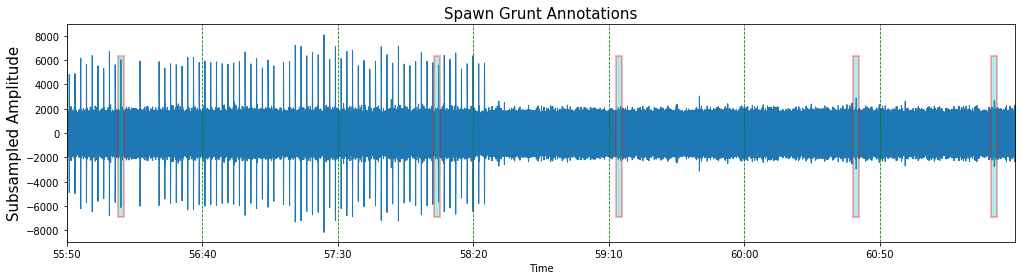

In [278]:
%matplotlib inline

def plot_sound_and_annotation(samples, annotations, sample_rate, sec_range = (0,200)):
    # subsample the data due to the large data size    
    max_len_subsample = min(5000000, samples.shape[0])
    ind = np.linspace(0, samples.shape[0]-1, max_len_subsample).astype(int)
    # print(ind, samples.shape)
    
    sub_samples = samples[ind]
    
    # for the annotation, change the values from time-frame to seconds
    sub_annotations = annotations/sample_rate
        
    # generate the corresponding seconds of the subsampled data
    seconds = np.linspace(0,samples.shape[0], max_len_subsample)/ sample_rate
    # print(max_len_subsample, seconds)
    
    # customize the range in seconds to plot
    sec_range = np.arange(sec_range[0], min(sec_range[1], seconds.max()) )*sample_rate /(samples.shape[0]/max_len_subsample)
    sec_range = sec_range.astype(int)
    
    plt.figure(0)
    fig, ax = plt.subplots(1, figsize=(17,4))  #  plt.figure(figsize=(15,4))
    ax.plot(seconds[sec_range],sub_samples[sec_range], label='Audio')
    
    rect_ymin = sub_samples[sec_range].min()*0.75
    rect_height = (sub_samples[sec_range].max()-sub_samples[sec_range].min())*0.75
    for lab in sub_annotations:
        
        if lab[0]>seconds[sec_range[-1]]:
            continue
        rect = patches.Rectangle((lab[0]-1,rect_ymin),  lab[1]-lab[0]+2,  rect_height, 
                                 linewidth=2,edgecolor='r',facecolor='c', alpha=0.3)

        ax.add_patch(rect)
        
    # Show the info.
    plt.grid(1, color='g', linestyle='--', axis = 'x', which='major')
    plt.xlabel('Time [s]', fontsize=15)
    plt.ylabel('Subsampled Amplitude', fontsize=15)
    plt.title('Spawn Grunt Annotations', fontsize=15)

def plot_sound_and_annotation_librosa(samples, annotations, sample_rate, sec_range = (0,200)):
    
    annotations = annotations/sample_rate
    
#     # subsample the data due to the large data size    
#     sub_sample_rate = 8000
#     ind = np.linspace(0, samples.shape[0]-1, int(samples.shape[0]*sub_sample_rate/sample_rate)).astype(int)
#     # print(ind, samples.shape)
    
#     sub_samples = samples[ind]
#     # print(sub_samples.shape, samples.shape)
#     seconds = np.arange(0,len(sub_samples))/ sub_sample_rate
#     # print('Seconds:', seconds[:100])

#     sec_range = np.arange(max(0, sec_range[0])*sub_sample_rate, min(sec_range[1], seconds.max())*sub_sample_rate)
#     sec_range = sec_range.astype(int)
#     # print(sec_range.shape)
    fig, ax = plt.subplots(1, figsize=(17,4))
#     librosa.display.waveplot(sub_samples[sec_range], sr=sub_sample_rate, 
#                              offset = sec_range[0], max_sr = 50)
    
    sec_range = np.arange(max(0, sec_range[0])*sample_rate, sec_range[1]*sample_rate)
    librosa.display.waveplot(samples[sec_range], sr=sample_rate, 
                             offset = sec_range[0]/sample_rate, max_sr = 30)
    
    max_second = len(samples)/sample_rate
    rect_ymin = samples[sec_range].min()*0.85
    rect_height = (samples[sec_range].max()-samples[sec_range].min())*0.85
    for lab in annotations:
        
        if lab[0]>max_second:
            continue
        rect = patches.Rectangle((lab[0]-1,rect_ymin),  lab[1]-lab[0]+2,  rect_height, 
                                 linewidth=2,edgecolor='r',facecolor='c', alpha=0.3)
    
        ax.add_patch(rect)
        
    # Show the info.
    plt.grid(1, color='g', linestyle='--', axis = 'x', which='major')
#     plt.xlabel('Time [s]', fontsize=15)
    plt.ylabel('Subsampled Amplitude', fontsize=15)
    plt.title('Spawn Grunt Annotations', fontsize=15)
    
# change seconds to sampling time-frame    
times_sounds_fs = times_sounds * sample_rate
times_sounds_fsr = times_sounds_fs.applymap(math.ceil)
  
labels = times_sounds_fsr.values

# plot_sound_and_annotation(samples[:20000], labels[:50])
plot_sound_and_annotation_librosa(samples, labels, sample_rate, (3350,3700))


### Have a try of the grunts, according to the annotation

In [169]:
import IPython.display as ipd   
index_grunt = np.arange(1900000,2200000, 1) # label 1
# index_grunt = np.arange(1960000,2260000, 1) # label 2
# index_grunt = np.arange(8600000,8900000, 1) # label 3 - one skeptic grunt sound afterwards
# index_grunt = np.arange(9504000,9804000, 1) # label 4 
# index_grunt = np.arange(21216000,21516000, 1) # label 5 
                                 
# index_grunt = np.arange(1900000,21516000, 1) # first 5 grunts 

# index_noise = np.arange(2020000,2100000, 1)
# ipd.Audio(samples[index_grunt], rate = sample_rate) # load a local WAV file

# or by seconds
# duration = (33, 37)
# index_grunt = np.arange(int(duration[0]*sample_rate), int(duration[1]*sample_rate), 1)
# ipd.Audio(samples[index_grunt], rate = sample_rate) # load a local WAV file


### Perform denoising and grunts detection

In [289]:

# # gauss_kernel = np.array(signal.gaussian(21, std = 1))
# # gauss_kernel = gauss_kernel[-15:, np.newaxis]
# # gauss_kernel = gauss_kernel/gauss_kernel.sum()
# # a = Xdb[0:15,:]*gauss_kernel
# # print(Xdb[0:15,:2], '\n'*2,gauss_kernel[0:15], '\n'*2, a[0:15,:2], '\n'*2,
# #      Xdb[0:15,:2].sum(axis = 0), '\n'*2, a[0:15,:2].sum(axis = 0))
# gauss_kernel = np.array(signal.gausspulse(21, 2.0))
# prof1 = Xdb[0:15,:].astype(float)*gauss_kernel
# prof1 = prof1.sum(axis = 0)
# samples.shape[0]/sample_rate

In [292]:
%matplotlib inline
def get_regions(profiles):
    '''
    Get the interval regions of spawn grunts with profile of spectrogram
    '''
    prof_peaks = profiles - min(profiles)

    ind_nonzero = np.array(prof_peaks > 0).astype(int)
    ind_nonzero[:20] = 0
    ind_nonzero[-20:]=0

    ind_change = np.zeros(len(ind_nonzero))
    for i in range(len(ind_nonzero)-1):
        if ind_nonzero[i+1] - ind_nonzero[i] != 0:
            ind_change[i] = 1 

    indices = np.array(np.where(ind_change!=0))
    if not indices.any():
        return ''
    else:
        indices = np.reshape(indices,(-1, 2))
        indices = [e for e in indices]
        return indices


def show_regions(im2sh, prof_sm, sec, is_save=False, is_update=False, save_path = ''):
    plt.figure(1,figsize=(13, 2))
    
    if is_update:
        plt.clf()
        plt.imshow(im2sh)
        plt.plot((prof1_sm.max() - prof1_sm)/4, color=[1,0.96,0.3])
    
        sec = np.round((np.linspace(sec.min(), sec.max(), 10))*100).astype(float)/100 # with two digits after dot
        plt.xticks(np.linspace(0, Xdb.shape[1], 10), sec)
        plt.xlabel('Time [s]')
        plt.ylabel('Detected regions')
        plt.title(str(sec.min()) + ' -> ' + str(sec.max()))
        # plt.axis('off')
        
        display.clear_output(wait=True)
        display.display(plt.gcf())
        
    else:
        plt.imshow(im2sh)
        plt.plot((prof1_sm.max() - prof1_sm)/4, color=[1,0.96,0.3])
    
        sec = np.round((np.linspace(sec.min(), sec.max(), 10))*100).astype(float)/100 # with two digits after dot
        plt.xticks(np.linspace(0, Xdb.shape[1], 10), sec)
        plt.xlabel('Time [s]')
        plt.ylabel('Detected regions')
        plt.title(str(sec.min()) + ' -> ' + str(sec.max()))
        # plt.axis('off')
        
        display.clear_output(wait=True)
        display.display(plt.gcf())

In [264]:
3500*48000/200000


840.0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<Figure size 936x144 with 0 Axes>

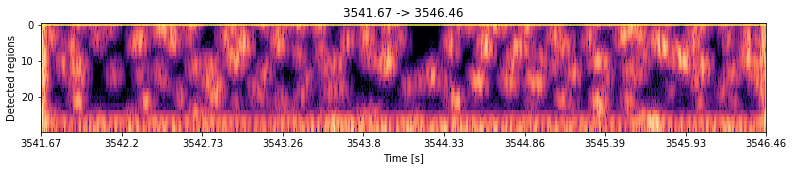

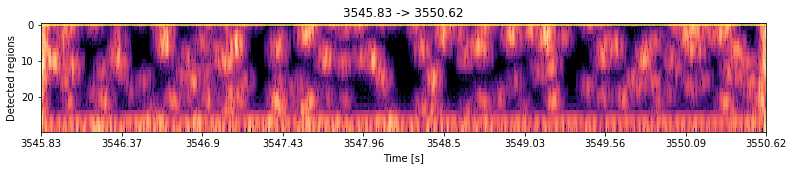

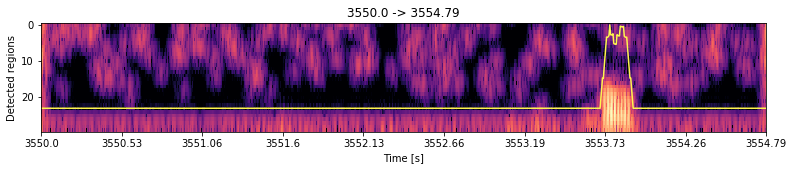

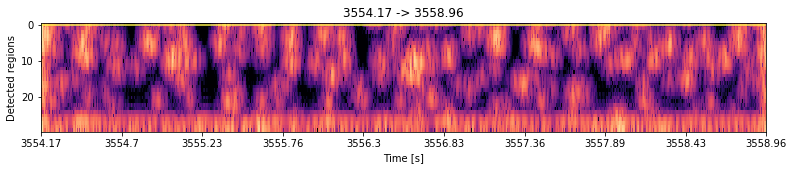

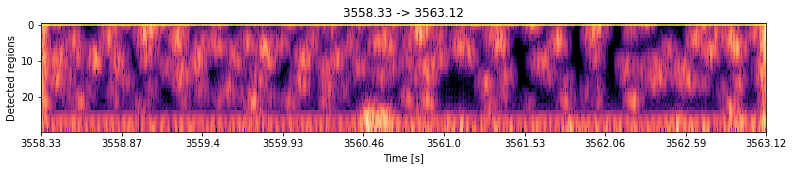

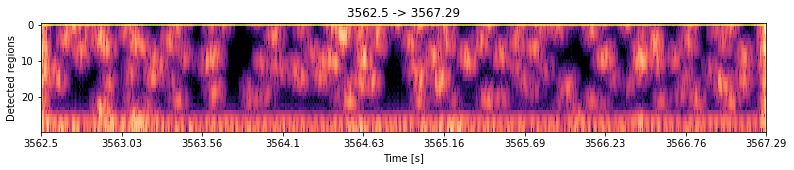

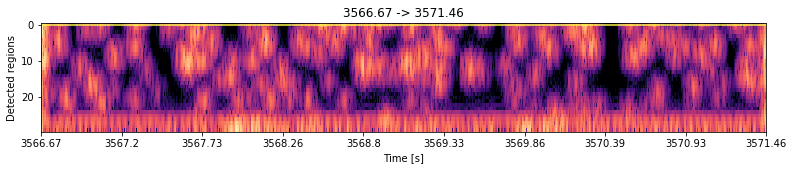

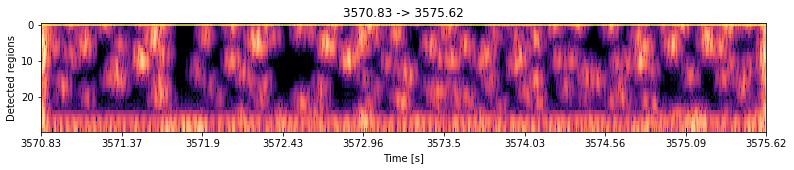

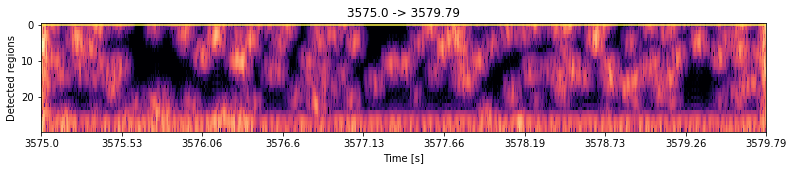

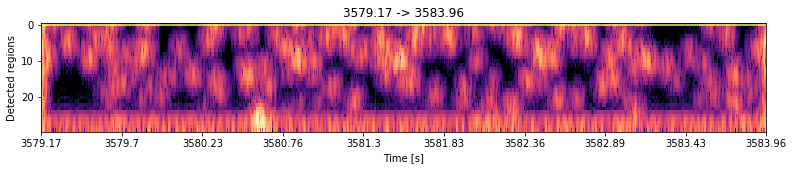

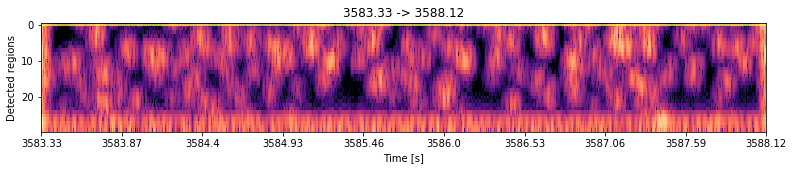

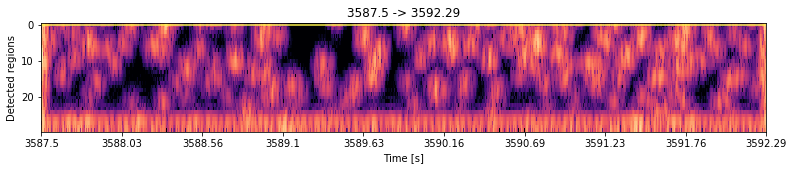

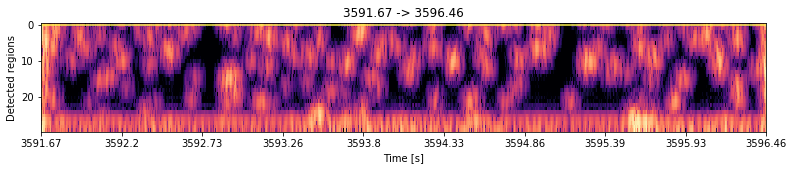

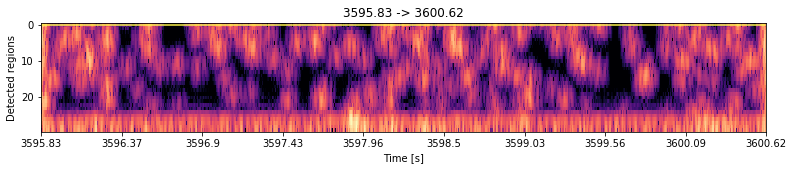

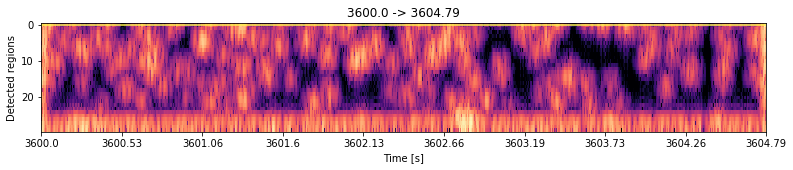

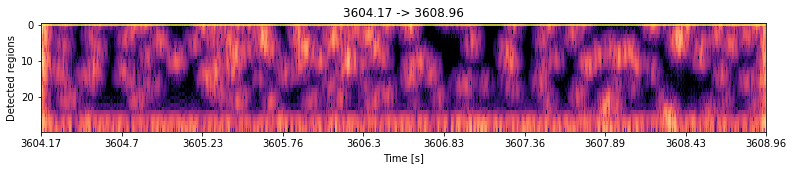

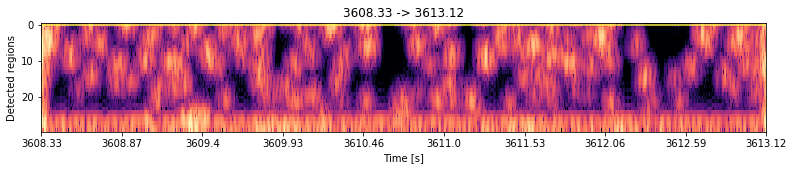

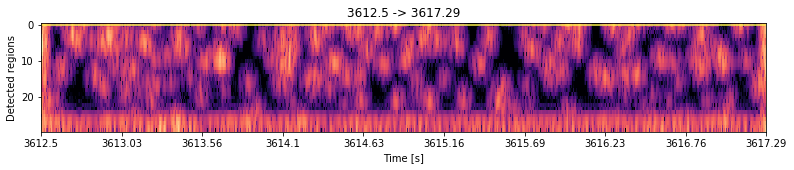

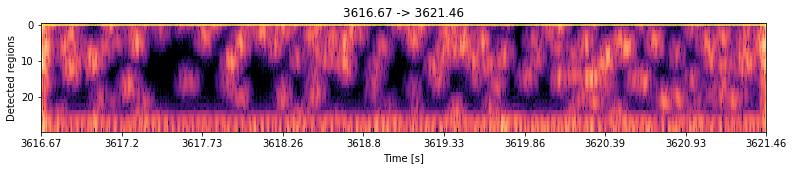

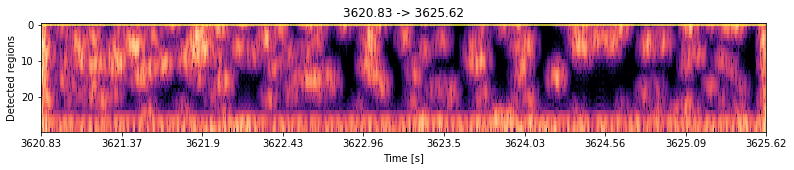

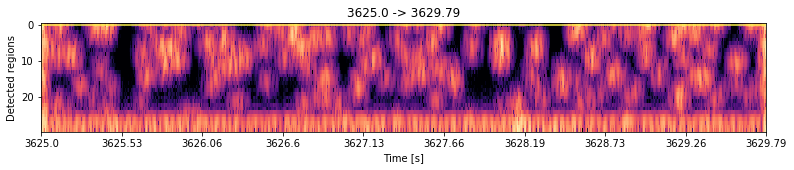

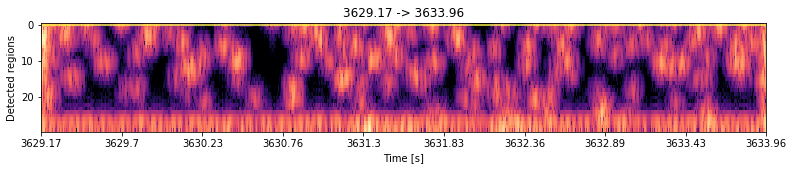

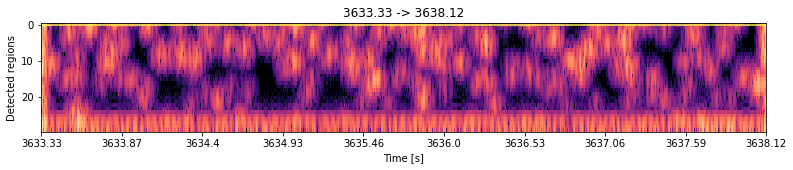

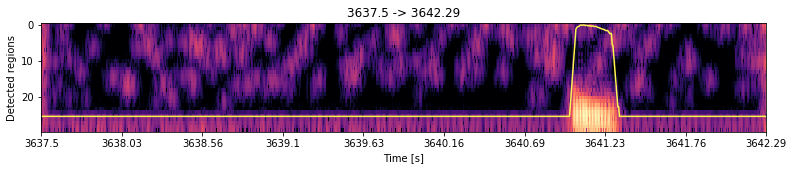

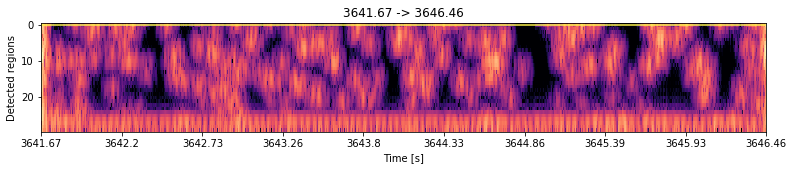

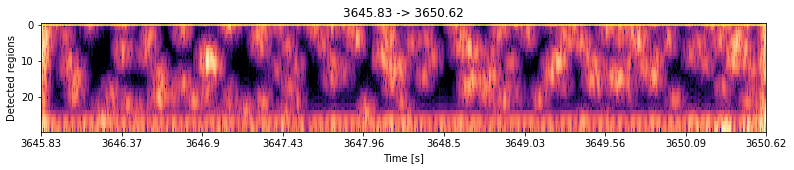

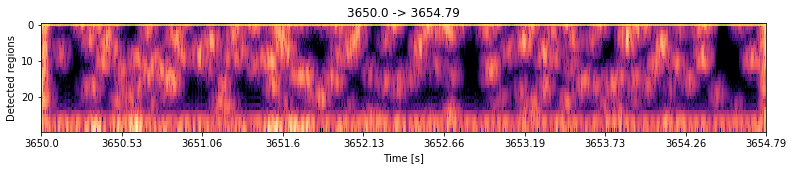

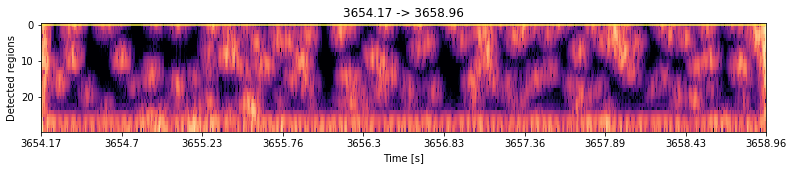

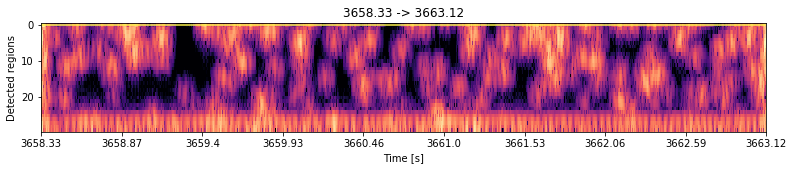

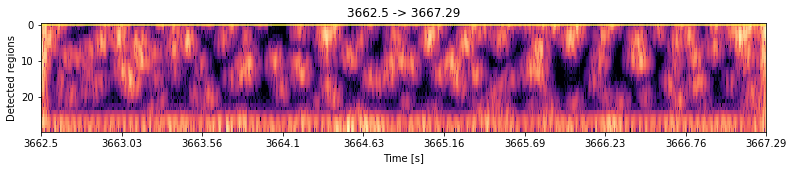

In [295]:
%matplotlib inline
from IPython.display import clear_output

import noisereduce as nr
import time as time
import scipy.signal as signal


# Parameters
piece_sz = 200000 # piece size of each iteration
overlay =  30000 # overlay size between two consecutive pieces

# gaussian kernels to filter vertically the signal
gauss_kernel = np.array(signal.gaussian(21, std = 2.28))
gauss_kernel = gauss_kernel[-15:, np.newaxis]
gauss_kernel = gauss_kernel/gauss_kernel.sum()

val_max = 0.0

plt.figure(figsize=(13, 2))
grunt_periods = []
for i in range(piece_sz*850, piece_sz*880, piece_sz): #samples.shape[0]-piece_sz-overlay, piece_sz):
    ind = np.arange(max(i, i-overlay+1),i+piece_sz+overlay,1)
    sec = ind/sample_rate
    
    
    # denoise
    piece = samples[ind]
    reduced_noise = nr.reduce_noise(audio_clip=piece, 
                                    noise_clip=piece,
                                    verbose=False)
    # calculate the spectrogram
    X = librosa.stft(reduced_noise.astype(float), n_fft = 2048, win_length=1024)
    Xdb = librosa.amplitude_to_db(abs(X))
    
    
#     clear_output(wait=True)
    plt.figure(figsize=(13, 2))
    plt.imshow(np.flipud(Xdb[0:30, ]), cmap = 'magma',aspect='auto', interpolation='nearest')
    
    # prof1 = Xdb[1:15,:].mean(0)
    prof1 = Xdb[0:15,:].astype(float)*gauss_kernel
    prof1 = prof1.sum(axis = 0)
    #     print(prof1)
    
    val_max = (max(prof1) + val_max)/2 if val_max!=0 else max(prof1)
    # print(val_max)
    
    #prof1[prof1<val_max*0.90]=0
    prof1[prof1<83]=0 # better
    
    prof1_sm = np.empty(prof1.shape)
    for i in range(0, len(prof1)):
        prof1_sm[i] = np.mean(prof1[max(0, i-4):min(i+4, len(prof1))])
    prof1_sm[:24] = prof1_sm.min()
    prof1_sm[-24:] = prof1_sm.min()
    
    plt.plot((prof1_sm.max() - prof1_sm)/4, color=[1,0.96,0.3])
    
    sec = np.round((np.linspace(sec.min(), sec.max(), 10))*100).astype(float)/100 # with two digits after dot
    plt.xticks(np.linspace(0, Xdb.shape[1], 10), sec)
    plt.xlabel('Time [s]')
    plt.ylabel('Detected regions')
    plt.title(str(sec.min()) + ' -> ' + str(sec.max()))
    
    
    # plt.savefig(os.path.join(filepath, 'Time '+str(sec.min())+'--'+str(sec.max())+'.png' ),  
    #              facecolor='w', edgecolor='w')
    
    ## get the grunts regions 
    #     pred_regions = get_regions(prof1_sm)
    #     # ind/sample_rate
    #     if pred_regions is list:
    #         print('\n*Indices:\n', pred_regions, 
    #               '\n*Seconds:\n', pred_regions/len(prof1_sm)*(sec.max()-sec.min()),
    #               '\n*Time Frames:\n', pred_regions/len(prof1_sm)*(sec.max()-sec.min()))
    #     else:
    #         pass
    

In [176]:
def get_regions(profiles):
    '''
    Get the interval regions of spawn grunts with profile of spectrogram
    '''
    prof_peaks = profiles - min(profiles)

    ind_nonzero = np.array(prof_peaks > 0).astype(int)
    ind_nonzero[:20] = 0
    ind_nonzero[-20:]=0

    ind_change = np.zeros(len(ind_nonzero))
    for i in range(len(ind_nonzero)-1):
        if ind_nonzero[i+1] - ind_nonzero[i] != 0:
            ind_change[i] = 1 

    indices = np.array(np.where(ind_change!=0))
    if not indices.any():
        return -1
    else:
        indices = np.reshape(indices,(-1, 2)) 
        return indices

pred_regions = get_regions(prof1_sm)
# ind/sample_rate
if pred_regions != -1:
    print('\n*Indices:\n', pred_regions, 
          '\n*Seconds:\n', pred_regions/len(prof1_sm)*(sec.max()-sec.min()),
          '\n*Time Frames:\n', pred_regions/len(prof1_sm)*(sec.max()-sec.min()))
else:
    print('No grunt detected')


*Indices:
 -1 
*Seconds:
 -0.005328142380422651 
*Time Frames:
 -0.005328142380422651


In [177]:
prof1_sm

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.